In [15]:
import TensorFrost as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import imageio
from IPython.display import Image
import os

N = 512

def Bilinear(tex, x, y):
    xi, yi = tf.floor(x), tf.floor(y)
    xf, yf = x-xi, y-yi
    xi, yi = tf.int(xi), tf.int(yi)
    oxf, oyf = 1.0-xf, 1.0-yf
    return tex[xi, yi]*oxf*oyf + tex[xi+1, yi]*xf*oyf + tex[xi, yi+1]*oxf*yf + tex[xi+1, yi+1]*xf*yf

def FluidTest():
    vx = tf.input([N, N], tf.float32)
    vy = tf.input([N, N], tf.float32)
    density = tf.input([N, N], tf.float32)
    pressure = tf.input([N, N], tf.float32)

    dt = 1.0

    # advect velocity
    i,j = vx.indices
    x, y = tf.float(i), tf.float(j)
    x1, y1 = x - vx*dt, y - vy*dt

    vx = Bilinear(vx, x1, y1)
    vy = Bilinear(vy, x1, y1)
    density = Bilinear(density, x1, y1)
    
    # add source
    source = 0.01*tf.exp(-((x-N/5.0)**2.0 + (y-N/2.0)**2.0)/100.0)
    source = source + 0.01*tf.exp(-((x-N/5.0)**2.0 + (y-N/3.0)**2.0)/100.0)
    density = density + source
    vx = vx + 0.5*source

    #edge = 1.0 - tf.float((i < 2) | (i > N-3) | (j < 2) | (j > N-3))

    # compute divergence
    div = (vx[i+1, j] - vx[i-1, j] + vy[i, j+1] - vy[i, j-1]) / 2.0

    # pressure solve
    for it in range(2):
        pressure = (pressure[i-1, j] + pressure[i+1, j] + pressure[i, j-1] + pressure[i, j+1] - div) / 4.0
    
    # subtract pressure gradient
    gradx = (pressure[i+1, j] - pressure[i-1, j])*1.5
    grady = (pressure[i, j+1] - pressure[i, j-1])*1.5
    vx = vx - gradx
    vy = vy - grady

    return [vx, vy, density, pressure]

tf.initialize(tf.cpu, "H:/cl_compile.bat /O2 /fp:fast /openmp:experimental")
fluid = tf.program(FluidTest)



dim =  2


In [16]:
VX = tf.memory(np.zeros((N, N)))
VY = tf.memory(np.zeros((N, N)))
DENSITY = tf.memory(np.zeros((N, N)))
PRESSURE = tf.memory(np.zeros((N, N)))

#do a few steps and measure performance by timing every 100 steps
start = time.time()

file_path = 'H:/TestVideos/fluid.gif'
writer = imageio.get_writer(file_path, fps=30)


for i in range(1000):
    VX, VY, DENSITY, PRESSURE = fluid(VX, VY, DENSITY, PRESSURE)

    if i % 10 == 0:
        writer.append_data(np.clip(DENSITY.numpy, 0.0, 1.0)*255.0)

    if i % 100 == 99:
        print("Iterations per second: " + str(100/(time.time()-start)))
        start = time.time()

writer.close()

Iterations per second: 217.39173701756422
Iterations per second: 294.11730881832176
Iterations per second: 292.3976542958565
Iterations per second: 307.69226254796797
Iterations per second: 307.6920368264681
Iterations per second: 302.114939415723
Iterations per second: 299.4013121592808
Iterations per second: 298.507641142104
Iterations per second: 300.30013517538436
Iterations per second: 302.114721803049


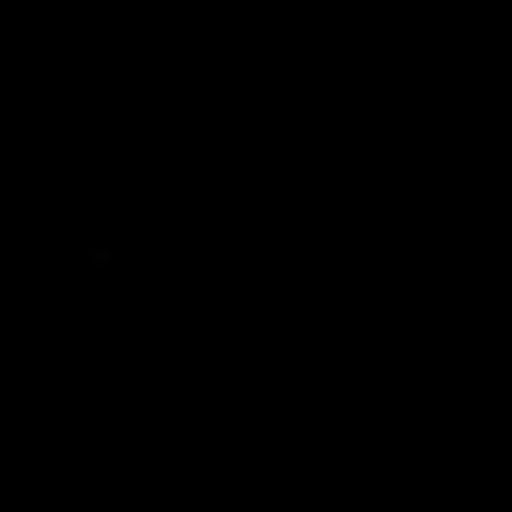

In [17]:
Image(file_path)

In [18]:
fluid.kernel_c()

#include <cmath> 
extern "C" 
{ 
typedef unsigned int uint; 

float asfloat(uint x) 
{ 
  return *(float*)&x; 
} 

uint asuint(float x) 
{ 
  return *(uint*)&x; 
} 

int clamp(int x, int min, int max) 
{ 
  if(x < min) return min; 
  if(x > max) return max; 
  return x; 
} 

void kernel_0(uint* variables, uint* offsets, uint* memory, uint thread_id)
{
  int var9_0 = thread_id;
  int var9_2 = var9_0 / 512;
  int var9_4 = var9_0 % 512;
  float var9_5 = (float)var9_4;
  float var9_6 = (float)var9_2;
  int var9_10 = clamp(var9_2, 0, 511);
  int var9_11 = var9_10 * 512;
  int var9_15 = clamp(var9_4, 0, 511);
  int var9_16 = var9_11 + var9_15;
  float var9_17 = asfloat(memory[offsets[0] + var9_16]);
  float var9_18 = var9_5 - var9_17;
  int var9_22 = clamp(var9_2, 0, 511);
  int var9_23 = var9_22 * 512;
  int var9_27 = clamp(var9_4, 0, 511);
  int var9_28 = var9_23 + var9_27;
  float var9_29 = asfloat(memory[offsets[1] + var9_28]);
  float var9_30 = var9_6 - var9_29;
  float var9_31 = floor(